# **Classification with XGB**
 Hpyerparameters are tuned with cross-validation and bayesian optimization


In [1]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11686 sha256=6f9d28f56d51c62e4420271f261e12a16ea5d23b854250d6426e78688a3de14a
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
from numpy.random import seed

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

import matplotlib.pyplot as plt

import xgboost as xgb
#import lightgbm as lgb
#import catboost as cat

from bayes_opt import BayesianOptimization
import pickle

## Load train dataset

In [149]:
data = pd. read_csv('df_train_dp0.csv')

data.describe()

,gleason_score,age,height,weight,family_history,first_degree_history,previous_cancer,smoker,tumor_diagnosis,tumor_1_year,psa_diagnosis,psa_1_year,tea,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,multi_thrpy,survival_1_year,t_score,n_score,m_score,stage,race_1,race_2,race_3,race_4,side_left,side_right,symp_U03,symp_O11,symp_U05,symp_O09,symp_U01,symp_P01,symp_S07,symp_S04,symp_P02,symp_U06,symp_O01,symp_O10,symp_P03,symp_S10,symp_O08,symp_U02,survival_7_years
count,14080.000000,13697.000000,13128.000000,13158.000000,12903.000000,12903.000000,12903.000000,12903.000000,14107.000000,12388.000000,13077.000000,12015.000000,12903.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.00000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000
mean,7.298509,76.896109,69.152803,176.808482,0.425637,0.212044,0.068589,0.054173,49.598923,38.280998,11.688942,9.107008,2.552120,0.537643,0.341189,0.663538,0.239625,0.246090,0.174835,0.778450,0.895655,6.710740,0.651999,0.159333,2.840806,0.059367,0.146889,0.040598,0.742440,0.699201,0.803684,0.34960,0.152033,0.103789,0.012861,0.605770,0.037887,0.397845,0.247341,0.025026,0.203337,0.022315,0.008412,0.008064,0.058533,0.015780,0.542579,0.432186
std,1.933190,9.637021,1.126814,17.118949,0.614782,0.460655,0.252763,0.226368,17.973946,32.710199,4.163123,6.038889,1.616137,0.498598,0.474125,0.472515,0.426869,0.430746,0.379839,0.415304,0.305718,2.932018,0.882404,0.597362,1.218241,0.236319,0.354008,0.197364,0.437306,0.458622,0.397224,0.47686,0.359066,0.304997,0.112677,0.488702,0.190929,0.489470,0.431482,0.156210,0.402495,0.147711,0.091331,0.089440,0.234757,0.124629,0.498201,0.495397
min,3.000000,32.000000,65.000000,118.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,71.000000,68.000000,166.000000,0.000000,0.000000,0.000000,0.000000,38.000000,8.000000,8.400000,4.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,78.000000,69.000000,174.000000,0.000000,0.000000,0.000000,0.000000,46.000000,34.000000,11.600000,8.800000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,7.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,9.000000,84.000000,70.000000,185.000000,1.000000,0.000000,0.000000,0.000000,58.000000,60.000000,14.900000,13.100000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,10.000000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,14.000000,107.000000,73.000000,343.000000,5.000000,4.000000,1.000000,1.000000,195.000000,225.000000,31.000000,35.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,2.000000,3.000000,4.000000,1.000000

In [150]:
data.shape

(14385, 48)

In [151]:
X = data.drop(columns='survival_7_years')
Y = data[['survival_7_years']]

In [152]:
seed(42)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(11508, 47) (2877, 47) (11508, 1) (2877, 1)


## XGB model

In [153]:
xgb_dtrain = xgb.DMatrix(data = X_train, label = Y_train)
xgb_dval = xgb.DMatrix(data = X_val, label = Y_val)


### Hyperparameter tuning

In [154]:
def obj_xgb(max_depth, eta, gamma, min_child_weight, subsample, 
            colsample_bytree, reg_lambda):
  
  params = {
      'booster' : 'gbtree', 
      'objective': 'binary:logistic',
      'eval_metric': 'auc'
   }  

  params['max_depth'] = int(round(max_depth))
  params['eta'] = max(min(eta, 1), 0)
  params['gamma'] = max(gamma, 0)
  params['min_child_weight'] = int(min_child_weight)
  params['subsample'] = max(min(subsample, 1), 0)
  params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
  params['lambda'] = max(reg_lambda, 0)

  scores = xgb.cv(params, 
                  xgb_dtrain, 
                  num_boost_round=100,
                  verbose_eval=False, 
                  early_stopping_rounds=5,
                  #feval=xgb_r2,
                  maximize=False,   # True causes issue with feval 
                  nfold=3)
  
  return  scores['test-auc-mean'].iloc[-1]  # for maximization  logloss

In [155]:
pds_xgb ={
  'max_depth': (2, 10),
  'eta': (0, 0.9),      #learning_rate
  'gamma': (0, 9),      #min_split_loss
  'min_child_weight': (10, 20),
  'subsample': (0.1, 1),
  'colsample_bytree': (0.1, 1),
  'reg_lambda': (0, 1),
}

optimizer_xgb = BayesianOptimization(obj_xgb, pds_xgb, random_state=42)

optimizer_xgb.maximize(init_points=10, n_iter=20)

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | min_ch... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7062   |  0.4371   |  0.8556   |  6.588    |  6.789    |  11.56    |  0.156    |  0.1523   |
|  2        |  0.7381   |  0.8796   |  0.541    |  6.373    |  2.165    |  19.7     |  0.8324   |  0.2911   |
|  3        |  0.7391   |  0.2636   |  0.1651   |  2.738    |  6.198    |  14.32    |  0.2912   |  0.6507   |
|  4        |  0.7315   |  0.2255   |  0.2629   |  3.297    |  5.649    |  17.85    |  0.1997   |  0.5628   |
|  5        |  0.74     |  0.6332   |  0.04181  |  5.468    |  3.364    |  10.65    |  0.9489   |  0.9691   |
|  6        |  0.7401   |  0.8276   |  0.2742   |  0.879    |  7.474    |  14.4     |  0.122    |  0.5457   |
|  7        |  0.7051   |  0.1309   |  0.8184   |  2.329    |  7.3      |  13.12    |  0.5201   |  0.592    |
|  8      

In [156]:
op_xgb = optimizer_xgb.max['params']
op_xgb

{'colsample_bytree': 0.8471610841287667,
 'eta': 0.126274293460883,
 'gamma': 8.865836235754792,
 'max_depth': 3.6912969252974577,
 'min_child_weight': 19.613729572292712,
 'reg_lambda': 0.049693552277711106,
 'subsample': 0.6189948678101569}

### Train model

In [157]:
params_xgb = {
    'booster' : 'gbtree', 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'colsample_bytree': 0.9, 
    'eta': 0.05,  #0.04
    'gamma': 5, #5
    'max_depth': 5, #4
    'min_child_weight': 10,
    'reg_lambda': 0.9,
    'subsample': 0.9,
}


watchlist = [(xgb_dval, 'eval'), (xgb_dtrain, 'train')]
num_round = 100

start = datetime.now()   
model_xgb = xgb.train(params_xgb, 
                      xgb_dtrain, 
                      num_round,
                      watchlist,
                      early_stopping_rounds=20, 
                      )
         
exe_time_xgb = datetime.now() - start   # supposed to be faster than sklearn wrapper

print("XGB execution time: ", exe_time_xgb)

[0]	eval-auc:0.736259	train-auc:0.745252
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 20 rounds.
[1]	eval-auc:0.742961	train-auc:0.75259
[2]	eval-auc:0.746214	train-auc:0.753978
[3]	eval-auc:0.747295	train-auc:0.754838
[4]	eval-auc:0.747249	train-auc:0.755716
[5]	eval-auc:0.748435	train-auc:0.756293
[6]	eval-auc:0.74861	train-auc:0.756154
[7]	eval-auc:0.748117	train-auc:0.75645
[8]	eval-auc:0.748604	train-auc:0.757225
[9]	eval-auc:0.750654	train-auc:0.758486
[10]	eval-auc:0.751233	train-auc:0.758937
[11]	eval-auc:0.750639	train-auc:0.759112
[12]	eval-auc:0.750522	train-auc:0.759904
[13]	eval-auc:0.75062	train-auc:0.760271
[14]	eval-auc:0.751156	train-auc:0.761132
[15]	eval-auc:0.751404	train-auc:0.761833
[16]	eval-auc:0.751207	train-auc:0.762107
[17]	eval-auc:0.751081	train-auc:0.762579
[18]	eval-auc:0.751565	train-auc:0.762743
[19]	eval-auc:0.751801	train-auc:0.763444
[20]	eval-auc:0.752005	train-au

### Evaluate

In [158]:
pred_xgb = model_xgb.predict(xgb_dval)
pred_xgb = pred_xgb>0.5


In [159]:
# make sure no one who not 'survival_1_year' but 'survival_7_years'
pred_xgb[X_val['survival_1_year']==0].sum()

0

In [160]:
print(f'Accuracy: {accuracy_score(Y_val, pred_xgb)}')
print(f'Precision: {precision_score(Y_val, pred_xgb)}')
print(f'Recall: {recall_score(Y_val, pred_xgb)}')
print(f'F1: {f1_score(Y_val, pred_xgb)}')

Accuracy: 0.681265206812652
Precision: 0.6395080707148347
Recall: 0.65
F1: 0.644711352189074


### Feature importance

In [161]:
model_xgb.get_score(importance_type='weight')

{'age': 117,
 'brch_thrpy': 12,
 'chm_thrpy': 2,
 'cry_thrpy': 1,
 'family_history': 6,
 'first_degree_history': 4,
 'gleason_score': 103,
 'h_thrpy': 10,
 'height': 17,
 'm_score': 71,
 'multi_thrpy': 11,
 'n_score': 50,
 'previous_cancer': 3,
 'psa_1_year': 88,
 'psa_diagnosis': 90,
 'race_1': 5,
 'race_2': 4,
 'race_3': 1,
 'race_4': 1,
 'rad_rem': 18,
 'rd_thrpy': 45,
 'side_left': 1,
 'side_right': 4,
 'stage': 15,
 'survival_1_year': 78,
 'symp_O01': 1,
 'symp_O08': 10,
 'symp_O09': 7,
 'symp_O11': 8,
 'symp_P01': 1,
 'symp_P02': 2,
 'symp_S04': 4,
 'symp_S07': 1,
 'symp_S10': 33,
 'symp_U01': 2,
 'symp_U02': 3,
 'symp_U05': 43,
 'symp_U06': 3,
 't_score': 30,
 'tea': 14,
 'tumor_1_year': 142,
 'tumor_diagnosis': 37,
 'weight': 76}

In [162]:
xgb_feat_imp = model_xgb.get_score(importance_type='weight')
df_xgb_feat_imp = pd.DataFrame(list(xgb_feat_imp.values()), index=xgb_feat_imp.keys(), columns=['Feature_importance'])

df_xgb_feat_imp.sort_values(by=['Feature_importance'], ascending=False,inplace=True)
df_xgb_feat_imp

,Feature_importance
tumor_1_year,142
age,117
gleason_score,103
psa_diagnosis,90
psa_1_year,88
survival_1_year,78
weight,76
m_score,71
n_score,50
rd_thrpy,45


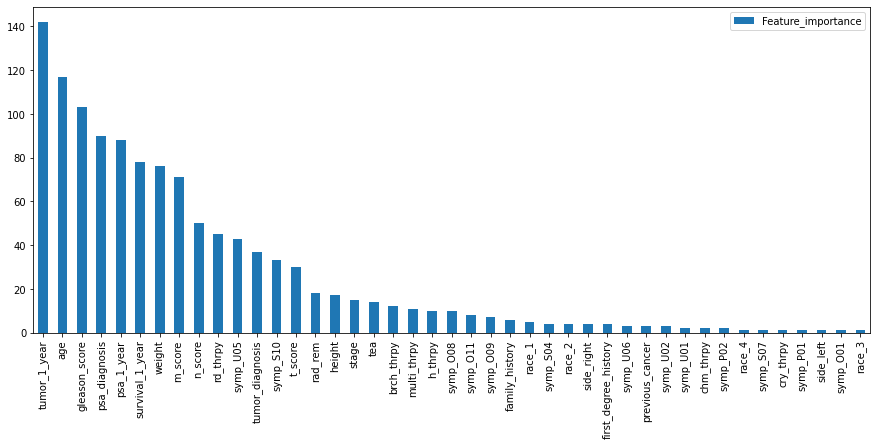

In [163]:
df_xgb_feat_imp.plot.bar(figsize=(15, 6))
#ax.invert_yaxis()

In [164]:
df_xgb_feat_imp.shape

(43, 1)

In [165]:
list(df_xgb_feat_imp.index)

['tumor_1_year',
 'age',
 'gleason_score',
 'psa_diagnosis',
 'psa_1_year',
 'survival_1_year',
 'weight',
 'm_score',
 'n_score',
 'rd_thrpy',
 'symp_U05',
 'tumor_diagnosis',
 'symp_S10',
 't_score',
 'rad_rem',
 'height',
 'stage',
 'tea',
 'brch_thrpy',
 'multi_thrpy',
 'h_thrpy',
 'symp_O08',
 'symp_O11',
 'symp_O09',
 'family_history',
 'race_1',
 'symp_S04',
 'race_2',
 'side_right',
 'first_degree_history',
 'symp_U06',
 'previous_cancer',
 'symp_U02',
 'symp_U01',
 'chm_thrpy',
 'symp_P02',
 'race_4',
 'symp_S07',
 'cry_thrpy',
 'symp_P01',
 'side_left',
 'symp_O01',
 'race_3']

##Predict

In [167]:
df_test = pd. read_csv('df_test_dp0.csv')

df_test.describe()

,gleason_score,age,height,weight,family_history,first_degree_history,previous_cancer,smoker,tumor_diagnosis,tumor_1_year,psa_diagnosis,psa_1_year,tea,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,multi_thrpy,survival_1_year,t_score,n_score,m_score,stage,race_1,race_2,race_3,race_4,side_left,side_right,symp_U03,symp_O11,symp_U05,symp_O09,symp_U01,symp_P01,symp_S07,symp_S04,symp_P02,symp_U06,symp_O01,symp_O10,symp_P03,symp_S10,symp_O08,symp_U02
count,985.000000,940.000000,893.000000,910.000000,896.000000,896.000000,896.000000,896.000000,975.000000,874.000000,910.000000,853.000000,896.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,7.320812,76.973404,69.127660,176.678022,0.398438,0.209821,0.071429,0.065848,49.283077,37.840961,11.872637,9.254865,2.561384,0.535000,0.367000,0.662000,0.228000,0.230000,0.171000,0.781000,0.915000,6.610000,0.623000,0.18200,2.85100,0.064000,0.151000,0.041000,0.733000,0.731000,0.796000,0.345000,0.158000,0.103000,0.014000,0.595000,0.038000,0.42500,0.255000,0.026000,0.19200,0.023000,0.01200,0.010000,0.074000,0.016000,0.561000
std,1.937180,9.331565,1.137146,18.514724,0.596786,0.458993,0.257683,0.248155,17.623249,31.949181,4.223738,6.231515,1.649318,0.499023,0.482228,0.473265,0.419753,0.421043,0.376697,0.413776,0.279021,2.990793,0.862331,0.65674,1.19173,0.244875,0.358228,0.198389,0.442614,0.443662,0.403171,0.475606,0.364924,0.304111,0.117549,0.491138,0.191292,0.49459,0.436079,0.159215,0.39407,0.149978,0.10894,0.099549,0.261902,0.125538,0.496513
min,3.000000,40.000000,66.000000,132.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,71.000000,68.000000,166.000000,0.000000,0.000000,0.000000,0.000000,38.000000,10.000000,8.500000,4.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000,0.000000,0.00000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,78.000000,69.000000,174.000000,0.000000,0.000000,0.000000,0.000000,46.000000,33.000000,12.000000,9.200000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,7.000000,0.000000,0.00000,3.00000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
75%,9.000000,84.000000,70.000000,182.000000,1.000000,0.000000,0.000000,0.000000,56.500000,58.000000,15.100000,13.300000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,10.000000,2.000000,0.00000,4.00000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.00000,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
max,14.000000,97.000000,73.000000,318.000000,3.000000,3.000000,1.000000,1.000000,152.000000,173.000000,28.000000,35.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,2.000000,3.00000,4.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000

In [168]:
df_test.shape

(1000, 47)

In [169]:
xgb_dtest = xgb.DMatrix(data = df_test)

In [170]:
pred_test = model_xgb.predict(xgb_dtest)
pred_test = (pred_test>0.5).astype(int)

In [171]:
# check 'survival_1_year' vs 'survival_7_years' case
pred_test[df_test['survival_1_year']==0].sum()

0

In [172]:
pred_test

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,

## Output

In [173]:
out = pd. read_csv('test.csv')
out['survival_7_years'] = pred_test
out

,id,diagnosis_date,gleason_score,t_score,n_score,m_score,stage,age,race,height,weight,family_history,first_degree_history,previous_cancer,smoker,side,tumor_diagnosis,tumor_6_months,tumor_1_year,psa_diagnosis,psa_6_months,psa_1_year,tea,symptoms,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,multi_thrpy,survival_1_year,survival_7_years
0,14386,2003-04-01,10.0,T2a,N1,M0,IV,83.0,4.0,70.0,164.0,1.0,1.0,0.0,0.0,both,95.0,NaN,88.0,13.4,NaN,12.4,3.0,S07,1,0,1,0,0,1,1,1,0
1,14387,2004-08-01,9.0,T4,N0,M0,IV,80.0,4.0,70.0,156.0,0.0,0.0,0.0,0.0,right,44.0,NaN,39.0,12.7,NaN,10.9,3.0,"U01,U02,S07",1,0,1,0,0,0,1,1,0
2,14388,2001-09-01,7.0,T4,N1,M0,IV,74.0,2.0,67.0,166.0,0.0,0.0,0.0,0.0,both,NaN,NaN,NaN,13.4,NaN,11.0,3.0,"U01,U03,O11",1,0,1,0,1,0,1,1,0
3,14389,2003-11-01,8.0,T1a,N0,M0,IIB,73.0,4.0,70.0,NaN,0.0,0.0,0.0,0.0,right,79.0,66.0,67.0,8.8,8.2,6.6,1.0,"U01,U02,S07,S10",0,0,0,1,0,0,0,1,0
4,14390,2006-05-01,3.0,T1c,NX,M0,I,90.0,4.0,NaN,NaN,1.0,1.0,0.0,0.0,both,67.0,NaN,27.0,8.7,NaN,1.7,5.0,"S07,S04",0,0,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15381,2005-06-01,7.0,T3c,N0,M0,III,72.0,4.0,70.0,178.0,0.0,0.0,0.0,0.0,left,51.0,17.0,NaN,8.5,2.4,NaN,2.0,"U03,S07",0,0,1,0,1,0,1,0,0
996,15382,2004-12-01,7.0,T4,N0,M0,IV,77.0,4.0,NaN,205.0,0.0,0.0,0.0,0.0,both,87.0,NaN,65.0,6.1,NaN,0.0,2.0,"U02,S07,O11",1,0,0,0,0,0,0,1,1
997,15383,2001-01-01,8.0,T3c,N0,M0,III,64.0,4.0,NaN,174.0,2.0,2.0,0.0,1.0,right,32.0,NaN,15.0,12.8,NaN,NaN,1.0,"U01,U03",1,1,0,0,0,0,1,1,1
998,15384,2003-01-01,10.0,T4,N1,M1a,IV,79.0,4.0,69.0,177.0,0.0,0.0,0.0,0.0,left,NaN,35.0,42.0,14.0,12.3,12.6,2.0,"S04,P01",0,1,1,1,1,0,1,1,0


In [174]:
out.to_csv('test_result.csv', index = False)